In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
config = {
    # training
    "epochs": 500,
    "batch_size": 1,          # 1 utterance = 1 ODE
    "learning_rate": 1e-3,
    "lambda_phys": 1e-3,

    # optimizer
    "optimizer": "adam",
    "weight_decay": 0.0,

    # scheduler
    "use_scheduler": True,
    "scheduler": "reduce_on_plateau",
    "lr_patience": 20,
    "lr_factor": 0.5,
    "min_lr": 1e-6,

    # early stopping
    "early_stopping": True,
    "early_patience": 40,
    "min_delta": 1e-6,

    # model
    "embed_dim": 48,

    # physics
    "I": 1.0,
    "r": 1.0
}

In [19]:
'''
observed jaw kinematics : Iθ¨(t) + bθ˙(t) + kθ(t)  - torque = 0
I = inertia, b= damping, k = stiffness
learned articulatory embedding : z=fCNN​(θ,x,y)
input = (x: [theta, w, a], t ), embeddings
output = a(t) : force, (b,k,f_max)
constant : I = jaw intertia
            Moment arm = r
torque model = τ = r.a(t).f_max (simplified)
loss function: l_contrastive + l_kinetics
'''

'\nobserved jaw kinematics : Iθ¨(t) + bθ˙(t) + kθ(t)  - torque = 0\nI = inertia, b= damping, k = stiffness\nlearned articulatory embedding : z=fCNN\u200b(θ,x,y)\ninput = (x: [theta, w, a], t ), embeddings\noutput = a(t) : force, (b,k,f_max)\nconstant : I = jaw intertia\n            Moment arm = r\ntorque model = τ = r.a(t).f_max (simplified)\nloss function: l_contrastive + l_kinetics\n'

In [20]:
#dataset ready
#architecture
#gradients
#kinematics residual
#contrastive residual 
#training loop
# model evaluation 
#plotting residuals

In [21]:
data = np.load('./../src/feature_extraction/z_word_embeddings.npz')

word_ids = data["word_ids"]       # (N_words,)
embeddings = data["embeddings"]   # (N_words, D)

print(len(word_ids))
# Word embeddings as a single tensor
z_word_tensor = torch.tensor(
    embeddings,
    dtype=torch.float32
)  # shape: (N_words, D)

z_word_tensor.shape


25


torch.Size([25, 56])

In [22]:
#making data for the pinn model 
src_pattern = r'/workspace/Silent_Speech/dataset_sony/Normalized_dataset/recordings/*/*.csv'
features = ["theta"]
C = len(features)
print("1. Loading & Normalizing PER SUBJECT...")

files = glob.glob(src_pattern)

X, words, subjects = [], [], []
T = 150

for fp in files:
    try:
        df = pd.read_csv(fp)
        data = df[features].values
        #normalization
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        
        n_chunks = len(data) // T
        if n_chunks == 0:
            continue

        data = data[:n_chunks * T].reshape(n_chunks, T, len(features))
        X.append(data)

        word = os.path.basename(os.path.dirname(fp))
        subj = os.path.basename(fp).replace(".csv", "")

        words.extend([word] * n_chunks)
        subjects.extend([subj] * n_chunks)

    except Exception as e:
        print("Skipping:", fp, e)

X = np.vstack(X)  # (N, T, 5)
theta_all = X[..., 0] 
theta_all = torch.tensor(
    theta_all,
    dtype=torch.float32
)

1. Loading & Normalizing PER SUBJECT...


In [23]:
# unique words (strings)
unique_words = sorted(list(set(words)))
num_words = len(unique_words)

# map word string → embedding row
word_to_index = {w: i for i, w in enumerate(unique_words)}

In [24]:
# z_word_tensor: (num_words, D)
# must be in the SAME ORDER as unique_words

z_word_tensor = torch.tensor(
    embeddings,  # assuming embeddings are already ordered correctly
    dtype=torch.float32
)
theta_all = theta_all.to(device)        # (N, T)
z_word_tensor = z_word_tensor.to(device)  # (num_words, D)

assert z_word_tensor.shape[0] == num_words

In [25]:
class JawPINNDataset(Dataset):
    def __init__(self, theta_all, words, z_word_tensor, word_to_index):
        """
        theta_all     : (N, T)
        words         : list[str], length N
        z_word_tensor : (num_words, D)
        word_to_index : dict[str -> int]
        """
        self.theta_all = theta_all
        self.words = words
        self.z_word_tensor = z_word_tensor
        self.word_to_index = word_to_index

    def __len__(self):
        return self.theta_all.shape[0]

    def __getitem__(self, idx):
        theta_obs = self.theta_all[idx]   # (T,)
        word = self.words[idx]            # string
        z_idx = self.word_to_index[word]  # int

        return {
            "theta_obs": theta_obs.unsqueeze(1),
            "z_word": self.z_word_tensor[z_idx],
            "word_idx": torch.tensor(z_idx, dtype=torch.long)
        }


In [26]:
loader = DataLoader(
    JawPINNDataset(theta_all, words, z_word_tensor, word_to_index),
    batch_size=64,
    shuffle=True,
    drop_last=True
)

In [27]:
def make_time_tensor(batch_size, T, t0=0.0, t1=1.0, device="cuda"):
    t = torch.linspace(t0, t1, T, device=device)
    t = t.view(1, T, 1).repeat(batch_size, 1, 1)
    t.requires_grad_(True)
    return t

In [28]:
batch = next(iter(loader))
for batch in loader:
    theta_obs = batch["theta_obs"].to(device)  # (B, T, 1)
    z_word = batch["z_word"].to(device)        # (B, D)

    B, T, _ = theta_obs.shape

In [29]:
t = make_time_tensor(B, T)

z_exp = z_word.unsqueeze(1).expand(B, T, -1)   # (B,T,D)
pinn_input = torch.cat([t, z_exp], dim=-1)     # (B,T,1+D)

In [40]:
assert pinn_input.shape == (B, T, 1 + z_word.shape[1])
assert theta_obs.is_cuda
assert z_word.is_cuda
assert t.is_cuda
assert pinn_input.is_cuda
assert t.requires_grad


In [31]:
D=56
#shapes
assert theta_obs.shape == (B, T, 1), theta_obs.shape
assert z_word.shape == (B, D), z_word.shape
assert t.shape == (B, T, 1), t.shape
assert z_exp.shape == (B, T, D), z_exp.shape
assert pinn_input.shape == (B, T, 1 + D), pinn_input.shape

#device
assert theta_obs.is_cuda
assert z_word.is_cuda
assert t.is_cuda
assert pinn_input.is_cuda

#grad flags
assert t.requires_grad is True
assert theta_obs.requires_grad is False
assert z_word.requires_grad is False

print("ALL SHAPE + DEVICE CHECKS PASSED")

ALL SHAPE + DEVICE CHECKS PASSED


In [32]:
class TrajectoryNet(nn.Module):
    def __init__(self, z_dim, hidden=128):
        super().__init__()

        self.time_net = nn.Sequential(
            nn.Linear(1, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
        )

        self.out = nn.Linear(hidden + z_dim, 1)

    def forward(self, t, z):
        """
        t : (B,T,1)
        z : (B,D)
        """
        B, T, _ = t.shape

        h = self.time_net(t)                  # (B,T,H)
        z_exp = z.unsqueeze(1).expand(B, T, -1)

        h = torch.cat([h, z_exp], dim=-1)
        theta_hat = self.out(h)

        return theta_hat


In [33]:
class ControlNet(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(3, hidden),  # (θ, θ̇, t)
            nn.Tanh(),
            nn.Linear(hidden, 1),
            nn.Tanh()              # bounded control
        )

    def forward(self, theta, theta_dot, t):
        x = torch.cat([theta, theta_dot, t], dim=-1)
        return self.net(x)


In [34]:
class WordParameterTable(torch.nn.Module):
    def __init__(self, num_words):
        super().__init__()

        # unconstrained parameters
        self.raw_params = torch.nn.Parameter(
            torch.zeros(num_words, 3)
        )

    def forward(self, word_indices):
        """
        word_indices : (B,) long tensor
        """
        raw = self.raw_params[word_indices]   # (B,3)

        b = torch.nn.functional.softplus(raw[:, 0:1])
        k = torch.nn.functional.softplus(raw[:, 1:2])
        fmax = torch.nn.functional.softplus(raw[:, 2:3])

        return b, k, fmax


In [35]:
def time_derivatives(theta_hat, t):
    theta_dot = torch.autograd.grad(
        theta_hat,
        t,
        grad_outputs=torch.ones_like(theta_hat),
        create_graph=True
    )[0]

    theta_ddot = torch.autograd.grad(
        theta_dot,
        t,
        grad_outputs=torch.ones_like(theta_dot),
        create_graph=True
    )[0]

    return theta_dot, theta_ddot


In [36]:
def physics_residual(
    theta,
    theta_dot,
    theta_ddot,
    a,
    b,
    k,
    fmax,
    I,
    r
):
    """
    All inputs shape (B,T,1) except:
    b,k,fmax : (B,1)
    """
    B, T, _ = theta.shape

    b = b.view(B,1,1)
    k = k.view(B,1,1)
    fmax = fmax.view(B,1,1)

    residual = (
        I * theta_ddot +
        b * theta_dot +
        k * theta -
        r * a * fmax
    )

    return residual


In [38]:
# Constants
I = torch.tensor(1.0, device=device)
r = torch.tensor(1.0, device=device)

# Models
traj_net = TrajectoryNet(D).to(device)
ctrl_net = ControlNet().to(device)
param_net = WordParameterTable(D).to(device)

# Forward
theta_hat = traj_net(t, z_word)

theta_dot, theta_ddot = time_derivatives(theta_hat, t)

a = ctrl_net(theta_hat, theta_dot, t)

b, k, fmax = param_net(z_word)

residual = physics_residual(
    theta_hat,
    theta_dot,
    theta_ddot,
    a,
    b,
    k,
    fmax,
    I,
    r
)

IndexError: tensors used as indices must be long, int, byte or bool tensors

In [ ]:
assert residual.shape == (B, T, 1)
assert torch.isfinite(residual).all()

In [203]:
b, k, fmax = param_net(z_word)

assert b.shape == (B,1)
assert (b >= 0).all()
assert torch.isfinite(b).all()

print("✅ ParameterNet OK")

✅ ParameterNet OK


In [204]:
def pinn_loss(theta_hat, theta_obs, residual,
              lambda_data=1.0,
              lambda_phys=1.0):
    """
    theta_hat : (B,T,1)
    theta_obs : (B,T,1)
    residual  : (B,T,1)
    """

    # Data loss (trajectory matching)
    data_loss = torch.mean((theta_hat - theta_obs) ** 2)

    # Physics loss (ODE residual)
    phys_loss = torch.mean(residual ** 2)

    total_loss = (
        lambda_data * data_loss +
        lambda_phys * phys_loss
    )

    return total_loss, data_loss, phys_loss

In [205]:
traj_net = TrajectoryNet(D).to(device)
ctrl_net = ControlNet().to(device)
param_net = WordParameterTable(num_words).to(device)


params = (
    list(traj_net.parameters()) +
    list(ctrl_net.parameters()) +
    list(param_net.parameters())
)

optimizer = torch.optim.Adam(params, lr=1e-3)
I = torch.tensor(1.0, device=device)
r = torch.tensor(1.0, device=device)

num_epochs = 2000

lambda_data = 10.0
lambda_phys = 1.0

loss_log = []

for epoch in range(num_epochs):
    total_epoch_loss = 0.0

    for batch in loader:
        theta_obs = batch["theta_obs"].to(device)  # (B,T,1)
        z_word = batch["z_word"].to(device)        # (B,D)

        B, T, _ = theta_obs.shape

        # ---- time ----
        t = make_time_tensor(B, T, device=device)

        # ---- forward ----
        theta_hat = traj_net(t, z_word)
        theta_dot, theta_ddot = time_derivatives(theta_hat, t)

        a = ctrl_net(theta_hat, theta_dot, t)
        word_idx = batch["word_idx"].to(device)

        b, k, fmax = param_net(word_idx)

        residual = physics_residual(
            theta_hat,
            theta_dot,
            theta_ddot,
            a,
            b,
            k,
            fmax,
            I,
            r
        )

        # ---- loss ----
        loss, d_loss, p_loss = pinn_loss(
            theta_hat,
            theta_obs,
            residual,
            lambda_data,
            lambda_phys
        )

        # ---- backward ----
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    loss_log.append(total_epoch_loss)

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch:04d} | "
            f"Total: {total_epoch_loss:.4e} | "
            f"Data: {d_loss.item():.4e} | "
            f"Phys: {p_loss.item():.4e}"
        )


Epoch 0000 | Total: 3.1942e+02 | Data: 9.3545e-01 | Phys: 9.2779e-03
Epoch 0100 | Total: 2.7017e+02 | Data: 7.6233e-01 | Phys: 1.1029e-02
Epoch 0200 | Total: 2.7139e+02 | Data: 7.2927e-01 | Phys: 5.2420e-03
Epoch 0300 | Total: 2.7012e+02 | Data: 7.4437e-01 | Phys: 1.4104e-03
Epoch 0400 | Total: 2.7011e+02 | Data: 8.2569e-01 | Phys: 6.0563e-02
Epoch 0500 | Total: 2.6970e+02 | Data: 8.2918e-01 | Phys: 6.8097e-03
Epoch 0600 | Total: 2.6958e+02 | Data: 7.8141e-01 | Phys: 8.9358e-03
Epoch 0700 | Total: 2.6917e+02 | Data: 7.8727e-01 | Phys: 3.1104e-03
Epoch 0800 | Total: 2.7197e+02 | Data: 7.4685e-01 | Phys: 1.0580e-02
Epoch 0900 | Total: 2.6979e+02 | Data: 6.7533e-01 | Phys: 1.0388e-02
Epoch 1000 | Total: 2.6971e+02 | Data: 8.0227e-01 | Phys: 1.0014e-03
Epoch 1100 | Total: 2.6990e+02 | Data: 8.1898e-01 | Phys: 1.2318e-02
Epoch 1200 | Total: 2.6980e+02 | Data: 8.3787e-01 | Phys: 4.0664e-03
Epoch 1300 | Total: 2.6979e+02 | Data: 7.8153e-01 | Phys: 6.1638e-03
Epoch 1400 | Total: 2.6942e+02 | D

In [212]:
traj_net.eval()
ctrl_net.eval()
param_net.eval()

word_params = defaultdict(list)
word_controls = defaultdict(list)

batch = next(iter(loader))

theta_obs = batch["theta_obs"].to(device)
z_word = batch["z_word"].to(device)

B, T, _ = theta_obs.shape
t = make_time_tensor(B, T, device=device)

# ---- forward ----
theta_hat = traj_net(t, z_word)

theta_dot, _ = time_derivatives(theta_hat, t)

a = ctrl_net(theta_hat, theta_dot, t)

b, k, fmax = param_net(z_word)

# ---- collect features ----
for i in range(B):
    word_id = words[i]   # instance → word mapping

    word_params[word_id].append(
        torch.cat([b[i], k[i], fmax[i]]).detach().cpu()
    )

    word_controls[word_id].append(
        a[i,:,0].detach().cpu()
    )

# ---- evaluation metric ----
mse = torch.mean((theta_hat - theta_obs) ** 2)

print("Eval MSE:", mse.item())


Eval MSE: 0.7900726795196533


In [213]:
word_feature_dict = {}

for w in word_params:
    params = torch.stack(word_params[w])   # (N_inst, 3)
    controls = torch.stack(word_controls[w])  # (N_inst, T)

    feature_vec = torch.cat([
        params.mean(dim=0),                 # mean(b,k,fmax)
        params.std(dim=0),                  # std(b,k,fmax)
        controls.mean(dim=0).mean().unsqueeze(0),
        controls.std(dim=0).mean().unsqueeze(0),
        controls.abs().max(dim=1).values.mean().unsqueeze(0)
    ])

    word_feature_dict[w] = feature_vec.numpy()

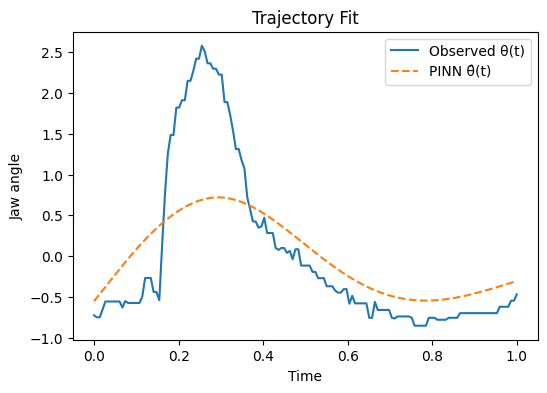

In [207]:
import matplotlib.pyplot as plt

i = 0  # first sample in batch

t_cpu = t[i,:,0].detach().cpu().numpy()
theta_true = theta_obs[i,:,0].cpu().numpy()
theta_pred = theta_hat[i,:,0].detach().cpu().numpy()

plt.figure(figsize=(6,4))
plt.plot(t_cpu, theta_true, label="Observed θ(t)")
plt.plot(t_cpu, theta_pred, "--", label="PINN θ̂(t)")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Jaw angle")
plt.title("Trajectory Fit")
plt.show()

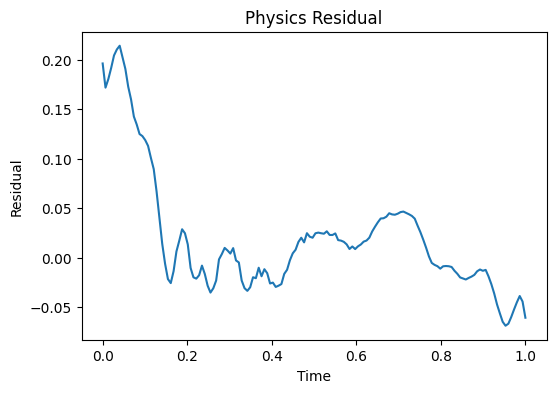

In [208]:
# recompute with gradients for residual
theta_hat = traj_net(t, z_word)
theta_dot, theta_ddot = time_derivatives(theta_hat, t)
a = ctrl_net(theta_hat, theta_dot, t)
b, k, fmax = param_net(z_word)

residual = physics_residual(
    theta_hat,
    theta_dot,
    theta_ddot,
    a,
    b,
    k,
    fmax,
    I,
    r
)

res = residual[i,:,0].detach().cpu().numpy()

plt.figure(figsize=(6,4))
plt.plot(t_cpu, res)
plt.xlabel("Time")
plt.ylabel("Residual")
plt.title("Physics Residual")
plt.show()

In [218]:
word_params

defaultdict(list,
            {'Piyaas': [tensor([ 3.8892, 44.8477,  8.6232]),
              tensor([ 3.8892, 44.8477,  8.6232]),
              tensor([ 3.8910, 44.8683,  8.6222]),
              tensor([ 3.8910, 44.8683,  8.6222]),
              tensor([ 3.8892, 44.8477,  8.6232]),
              tensor([ 3.8889, 44.8391,  8.6190]),
              tensor([ 3.8912, 44.8552,  8.6280]),
              tensor([ 3.8903, 44.8392,  8.6210]),
              tensor([ 3.8912, 44.8552,  8.6280]),
              tensor([ 3.8912, 44.8552,  8.6280]),
              tensor([ 3.8881, 44.8302,  8.6101]),
              tensor([ 3.8892, 44.8477,  8.6232]),
              tensor([ 3.8900, 44.8643,  8.6230]),
              tensor([ 3.8878, 44.8405,  8.6157]),
              tensor([ 3.8925, 44.8631,  8.6220]),
              tensor([ 3.8910, 44.8683,  8.6222]),
              tensor([ 3.8900, 44.8643,  8.6230]),
              tensor([ 3.8899, 44.8642,  8.6255]),
              tensor([ 3.8882, 44.8403,  8.6132]),
   